# Lane Fitting

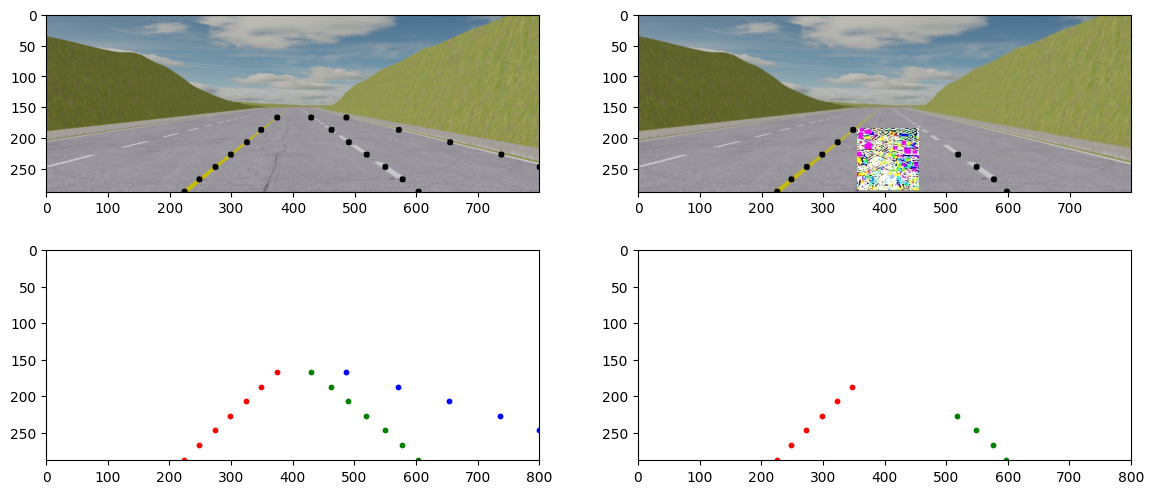

In [13]:
import os
from matplotlib import pyplot as plt
from utils.vis_utils import lane_detection_visualize_batched
from utils.lane_det_utils import lane_as_segmentation_inference
from utils.common import load_checkpoint
from utils.losses.builder import LOSSES
from utils.runners.base import BaseTrainer
from utils.models.builder import MODELS
from utils.args import read_config
import utils.transforms.functional as F
import numpy as np
from PIL import Image, ImageChops 
import torch

MODEL="baseline"
IMAGE_BASE='../../lanefitting/example_input.jpg'
IMAGE_ADV='../../lanefitting/adv_img_dpatched.jpg'

if MODEL == "baseline":
    CONFIG=os.path.dirname(os.getcwd()) + '/pytorch_auto_drive/configs/lane_detection/baseline/resnet50_culane.py'
    CHECKPOINT=os.path.dirname(os.getcwd()) + '/../../resnet50_baseline_culane_20210308.pt'
elif MODEL == "resa":
    CONFIG=os.path.dirname(os.getcwd()) + '/pytorch_auto_drive/configs/lane_detection/resa/resnet50_culane.py'
    CHECKPOINT=os.path.dirname(os.getcwd()) + '/../../resnet50_resa_culane_20211016.pt'
elif MODEL == "scnn":
    CONFIG=os.path.dirname(os.getcwd()) + '/pytorch_auto_drive/configs/lane_detection/scnn/resnet50_culane.py'
    CHECKPOINT=os.path.dirname(os.getcwd()) + '/../../resnet50_scnn_culane_20210311.pt'

cfg = read_config(CONFIG)
model = MODELS.from_dict(cfg['model'])

optimizer = BaseTrainer.get_optimizer(cfg['optimizer'], model)

loss_config = loss = dict(
    name='LaneLossSeg',
    ignore_index=255,
    weight=[0.4, 1, 1, 1, 1]
)

loss = LOSSES.from_dict(loss_config)
num_classes = cfg['train']['num_classes']
input_sizes = cfg['train']['input_size']
load_checkpoint(net=model, optimizer=None, lr_scheduler=None, filename=CHECKPOINT, strict=False)

image_base = Image.open(IMAGE_BASE)
image_adv_ = Image.open(IMAGE_ADV)
original_img = F.to_tensor(image_base.resize((input_sizes[1], input_sizes[0]))).clone().unsqueeze(0)
original_img_adv = F.to_tensor(image_adv_.resize((input_sizes[1], input_sizes[0]))).clone().unsqueeze(0)
image = F.resize(image_base, size=input_sizes) # type: ignore
image_adv = F.resize(image_adv_, size=input_sizes) # type: ignore

model_in = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
model_in_adv = torch.ByteTensor(torch.ByteStorage.from_buffer(image_adv.tobytes()))

model_in = model_in.view(image.size[1], image.size[0], len(image.getbands()))
model_in_adv = model_in_adv.view(image_adv.size[1], image_adv.size[0], len(image_adv.getbands()))

model_in = (
    model_in.permute((2, 0, 1)).contiguous().float().div(255).unsqueeze(0).numpy()
)
model_in_adv = (
    model_in_adv.permute((2, 0, 1)).contiguous().float().div(255).unsqueeze(0).numpy()
)

if not torch.cuda.is_available():
    device = torch.device("cpu")
else:  # pragma: no cover
    cuda_idx = torch.cuda.current_device()
    device = torch.device(f"cuda:{cuda_idx}")

results = model(torch.from_numpy(model_in).to(device))
results_adv = model(torch.from_numpy(model_in_adv).to(device))

keypoints = lane_as_segmentation_inference(
        None,
        results,
        [input_sizes, input_sizes],
        cfg['test']['gap'],
        cfg['test']['ppl'],
        cfg['test']['thresh'],
        cfg['test']['dataset_name'],
        cfg['test']['max_lane'],
        forward=False,  # already called model
    )
keypoints_adv = lane_as_segmentation_inference(
        None,
        results_adv,
        [input_sizes, input_sizes],
        cfg['test']['gap'],
        cfg['test']['ppl'],
        cfg['test']['thresh'],
        cfg['test']['dataset_name'],
        cfg['test']['max_lane'],
        forward=False,  # already called model
    )

keypoints = [[np.array(lane) for lane in image] for image in keypoints]
keypoints_adv = [[np.array(lane) for lane in image_adv] for image_adv in keypoints_adv]

infered_img = lane_detection_visualize_batched(original_img, keypoints=keypoints, style="point")[0]
infered_img_adv = lane_detection_visualize_batched(original_img_adv, keypoints=keypoints_adv, style="point")[0]
keypoints = keypoints[0]
keypoints_adv = keypoints_adv[0]

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14, 6))

ax1[0].imshow(infered_img)
ax1[1].imshow(infered_img_adv)

ax2[0].invert_yaxis()
ax2[0].set_xlim(0, input_sizes[1])
ax2[0].set_ylim(input_sizes[0], 0)

ax2[1].invert_yaxis()
ax2[1].set_xlim(0, input_sizes[1])
ax2[1].set_ylim(input_sizes[0], 0)

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, lane in enumerate(keypoints):
    for point in lane:
        ax2[0].scatter(point[0], point[1], s=10, c=colors[i], marker='o')

for i, lane in enumerate(keypoints_adv):
    for point in lane:
        ax2[1].scatter(point[0], point[1], s=10, c=colors[i], marker='o')




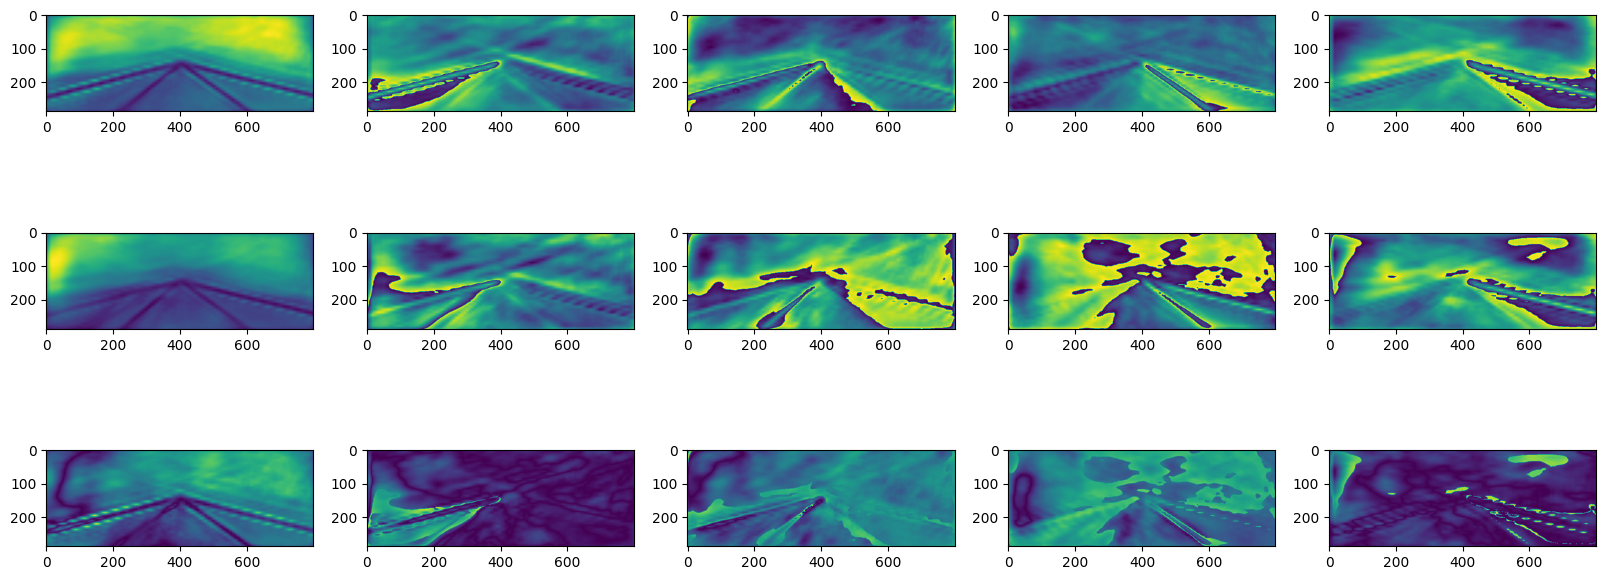

In [12]:
fig, (row1, row2, row3) = plt.subplots(3, 5, figsize=(20, 8))
prob_maps = torch.nn.functional.interpolate(results['out'], size=input_sizes, mode='bilinear', align_corners=True)
diffs = [None] * len(prob_maps[0])
for i, lane in enumerate(prob_maps[0]):
    pred =lane.detach().cpu().numpy()
    rescaled = (255.0/pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    diffs[i] = im
    row1[i].imshow(im)

prob_maps = torch.nn.functional.interpolate(results_adv['out'], size=input_sizes, mode='bilinear', align_corners=True)
for i, lane in enumerate(prob_maps[0]):
    pred =lane.detach().cpu().numpy()
    rescaled = (255.0/pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    diffs[i] = ImageChops.difference(diffs[i], im) 
    row2[i].imshow(im)

for i, image in enumerate(diffs):
    row3[i].imshow(image)
